In [2]:
!pip install gymnasium[box2d] numpy torch matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s eta 0:00:00
  er

In [3]:

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1", render_mode=None)

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
policy = PolicyNetwork(obs_dim, n_actions)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

def select_action(state):
    state = torch.FloatTensor(state)
    probs = policy(state)
    dist = torch.distributions.Categorical(probs)
    action = dist.sample()
    return action.item(), dist.log_prob(action)

In [7]:
def train(env, policy, episodes=500):
    all_rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        done = False
        while not done:
            action, log_prob = select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
            if done or truncated:
                break

        # Compute discounted rewards
        G = 0
        returns = []
        for r in reversed(rewards):
            G = r + 0.99 * G
            returns.insert(0, G)
        returns = torch.FloatTensor(returns)

        loss = -torch.stack(log_probs) @ returns
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_reward = sum(rewards)
        all_rewards.append(total_reward)
        if episode % 10 == 0:
            print(f"Episode {episode}, Return: {total_reward}")
    return all_rewards

Episode 0, Return: 17.0
Episode 10, Return: 16.0
Episode 20, Return: 10.0
Episode 30, Return: 9.0
Episode 40, Return: 10.0
Episode 50, Return: 10.0
Episode 60, Return: 12.0
Episode 70, Return: 12.0
Episode 80, Return: 27.0
Episode 90, Return: 18.0
Episode 100, Return: 11.0
Episode 110, Return: 22.0
Episode 120, Return: 68.0
Episode 130, Return: 24.0
Episode 140, Return: 140.0
Episode 150, Return: 195.0
Episode 160, Return: 279.0
Episode 170, Return: 182.0
Episode 180, Return: 153.0
Episode 190, Return: 225.0
Episode 200, Return: 229.0
Episode 210, Return: 315.0
Episode 220, Return: 490.0
Episode 230, Return: 202.0
Episode 240, Return: 220.0
Episode 250, Return: 155.0
Episode 260, Return: 103.0
Episode 270, Return: 101.0
Episode 280, Return: 118.0
Episode 290, Return: 169.0
Episode 300, Return: 109.0
Episode 310, Return: 185.0
Episode 320, Return: 184.0
Episode 330, Return: 268.0
Episode 340, Return: 250.0
Episode 350, Return: 207.0
Episode 360, Return: 165.0
Episode 370, Return: 144.0


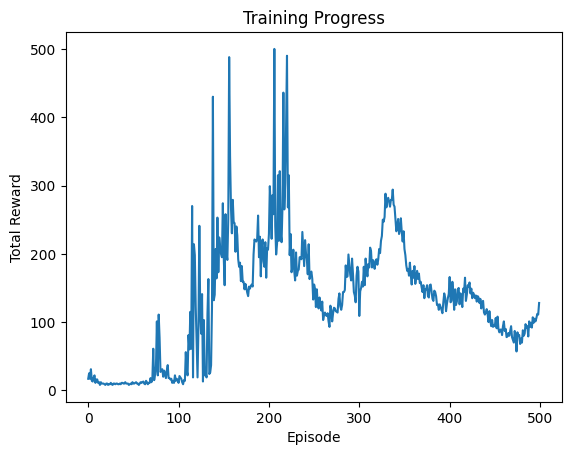

In [8]:
rewards = train(env, policy)

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress")
plt.show()